In [1]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from hmmlearn import hmm

from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
from ta.momentum import roc

from quant_invest_lab.data_provider import download_crypto_historical_data

In [2]:
symbol = "BTC-USDT"  # Best: BNB, BTC,
timeframe = "1hour"
df_BTC = download_crypto_historical_data(
    symbol, timeframe, True, False
)  # .loc["2020-11-20":]
df_BTC.dropna(inplace=True)

df_BTC["Returns"] = df_BTC.Close.pct_change()
df_BTC["Log_Returns"] = np.log(df_BTC.Close).pct_change()
df_BTC["Log_Volume"] = np.log(
    np.abs(df_BTC.Volume.apply(lambda x: 1.0 if x == 0.0 else x))
)
df_BTC["120_rolling_volatility"] = df_BTC.Log_Returns.rolling(120).std()
df_BTC["50_rolling_volatility"] = df_BTC.Log_Returns.rolling(50).std()
df_BTC["20_rolling_volatility"] = df_BTC.Log_Returns.rolling(20).std()
df_BTC["EMA20"] = df_BTC.Close.ewm(20).mean()
df_BTC["ROC21"] = roc(df_BTC.Close, 21)
df_BTC["ROC64"] = roc(df_BTC.Close, 64)
df_BTC["ROC256"] = roc(df_BTC.Close, 256)

df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()

(48598, 17)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Returns,Log_Volume,120_rolling_volatility,50_rolling_volatility,20_rolling_volatility,EMA20,ROC21,ROC64,ROC256
Date,,,,,,,,,,,,,,,,,
2017-10-29 09:00:00,1.509264e+09,5750.000001,5879.000000,5879.999993,5750.000001,0.546944,3213.458739,-1.700668e-04,-1.959617e-05,8.075103,0.003402,0.002739,0.002640,5780.826560,1.362069,-1.688963,36.498723
2017-10-29 10:00:00,1.509268e+09,5877.890000,5877.999998,5878.000000,5750.000001,0.634864,3730.984761,-1.700973e-04,-1.960007e-05,8.224427,0.003401,0.002714,0.002637,5785.453882,-1.623431,-1.853398,36.475505
2017-10-29 11:00:00,1.509271e+09,5770.000000,5875.999998,5875.999999,5451.000001,0.283806,1624.187608,-3.402518e-04,-3.921083e-05,7.392763,0.003401,0.002714,0.002484,5789.765616,-2.050342,-1.886792,67.885714
2017-10-29 12:00:00,1.509275e+09,5875.999999,5875.999999,5876.000000,5490.000001,0.226119,1290.077653,1.701836e-10,1.960943e-11,7.162458,0.003401,0.002714,0.002435,5793.872028,1.310345,-0.406780,20.905350
2017-10-29 13:00:00,1.509278e+09,5780.000001,5790.000001,5875.999999,5471.000000,0.226365,1295.202450,-1.463581e-02,-1.698881e-03,7.166422,0.003385,0.002715,0.002430,5793.687645,1.578947,0.381415,50.389610


In [5]:
model = MarkovRegression(
    df_BTC.Close, k_regimes=2, trend="c", switching_variance=False, order=1
)
res_kns = model.fit()
res_kns.summary()

In [ ]:
df_BTC["Low_regime_proba"] = tuple(res_kns.smoothed_marginal_probabilities[0])
df_BTC["High_regime_proba"] = tuple(res_kns.smoothed_marginal_probabilities[1])

df_BTC.loc[df_BTC["Low_regime_proba"] < df_BTC["High_regime_proba"], "Regime"] = 1
df_BTC.loc[df_BTC["Low_regime_proba"] > df_BTC["High_regime_proba"], "Regime"] = 2
df_BTC["Regime"] = df_BTC["Regime"].astype(int)

df_BTC.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Returns,Low_regime_proba,High_regime_proba,Regime
Date,,,,,,,,,,,,
2020-11-20 01:00:00,1.605830e+09,17802.8,17777.1,17932.8,17759.4,50.896954,9.085195e+05,-0.001606,-0.000164,0.500171,0.499829,2
2020-11-20 02:00:00,1.605834e+09,17777.1,17964.4,17966.2,17747.4,51.114373,9.134070e+05,0.010536,0.001071,0.498887,0.501113,1
2020-11-20 03:00:00,1.605838e+09,17960.3,17957.5,18034.8,17920.1,102.944213,1.851233e+06,-0.000384,-0.000039,0.500042,0.499958,2
2020-11-20 04:00:00,1.605841e+09,17957.5,17953.5,18018.7,17938.0,32.661923,5.871090e+05,-0.000223,-0.000023,0.500025,0.499975,2
2020-11-20 05:00:00,1.605845e+09,17955.9,18192.1,18230.7,17943.2,121.304551,2.196964e+06,0.013290,0.001348,0.498596,0.501404,1


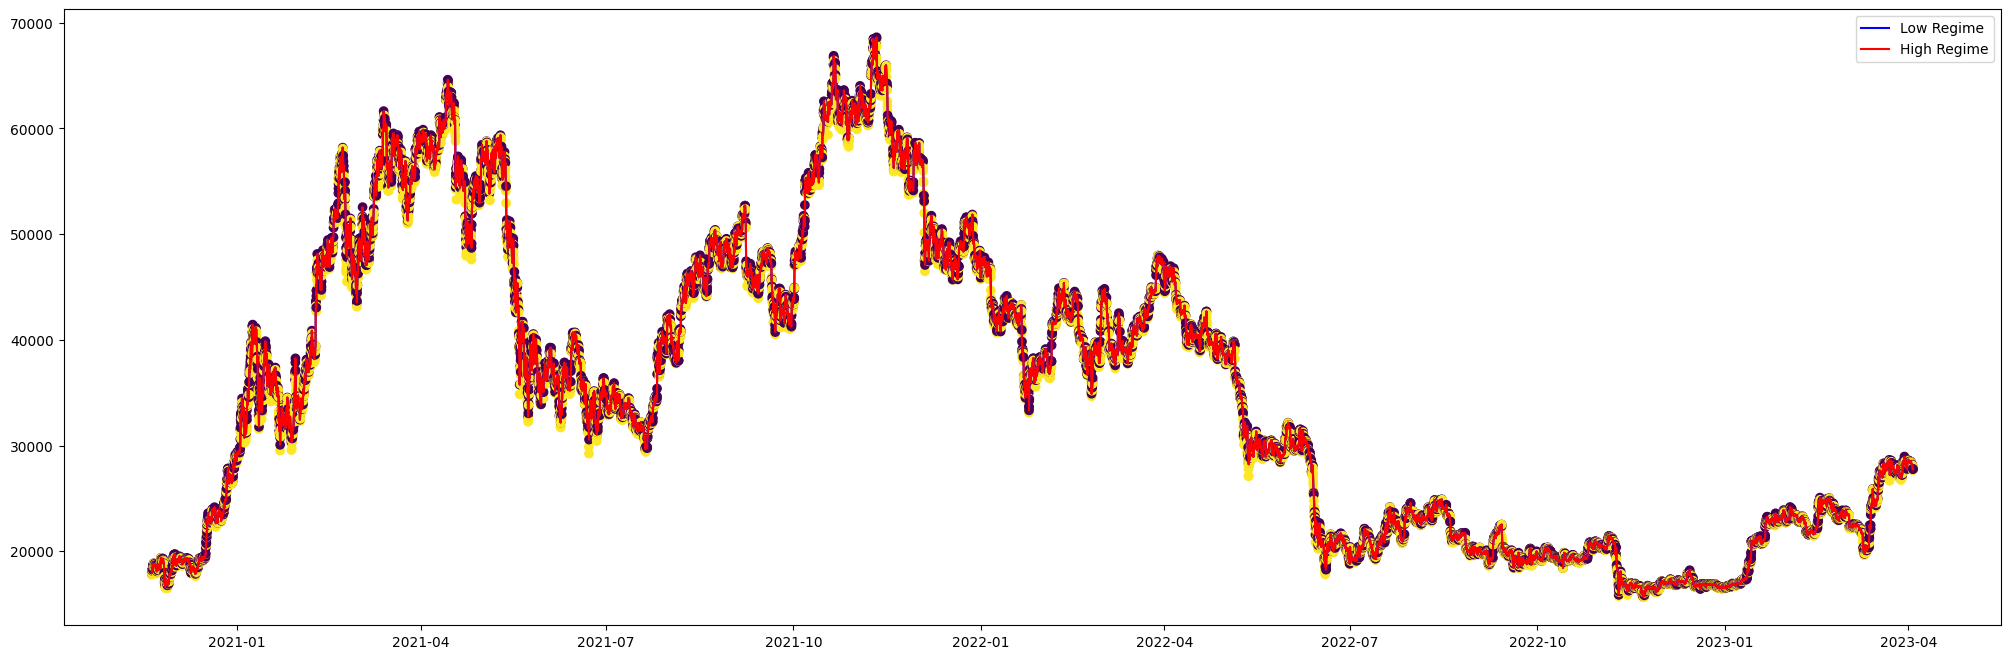

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))

plt.plot(
    df_BTC.loc[df_BTC["Regime"] == 1].index,
    df_BTC.loc[df_BTC["Regime"] == 1]["Close"],
    c="blue",
    label="Low Regime",
)
plt.plot(
    df_BTC.loc[df_BTC["Regime"] == 1].index,
    df_BTC.loc[df_BTC["Regime"] == 1]["Close"],
    c="red",
    label="High Regime",
)
plt.scatter(
    df_BTC.index,
    df_BTC["Close"],
    c=df_BTC.Regime.values,
)
plt.legend()

# With HMM Learn


**hmmlearn** allows us to place certain constraints on the covariance matrices of the multivariate Gaussian distributions.

- `covariance_type = "diag"` — the covariance matrix for each hidden state is a diagonal matrix, and these matrices may be different.
- `covariance_type = "spherical"` — the covariance matrix for each hidden state is proportional to the identity matrix, and these matrices may be different.
- `covariance_type = "full"` — no restrictions placed on the covariance matrices for any of the hidden states.
- `covariance_type = "tied"` — all hidden states share the same full covariance matrix.


In [55]:
from sklearn.decomposition import PCA

# Create a PCA instance: model
model = PCA()

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(df_BTC.values)

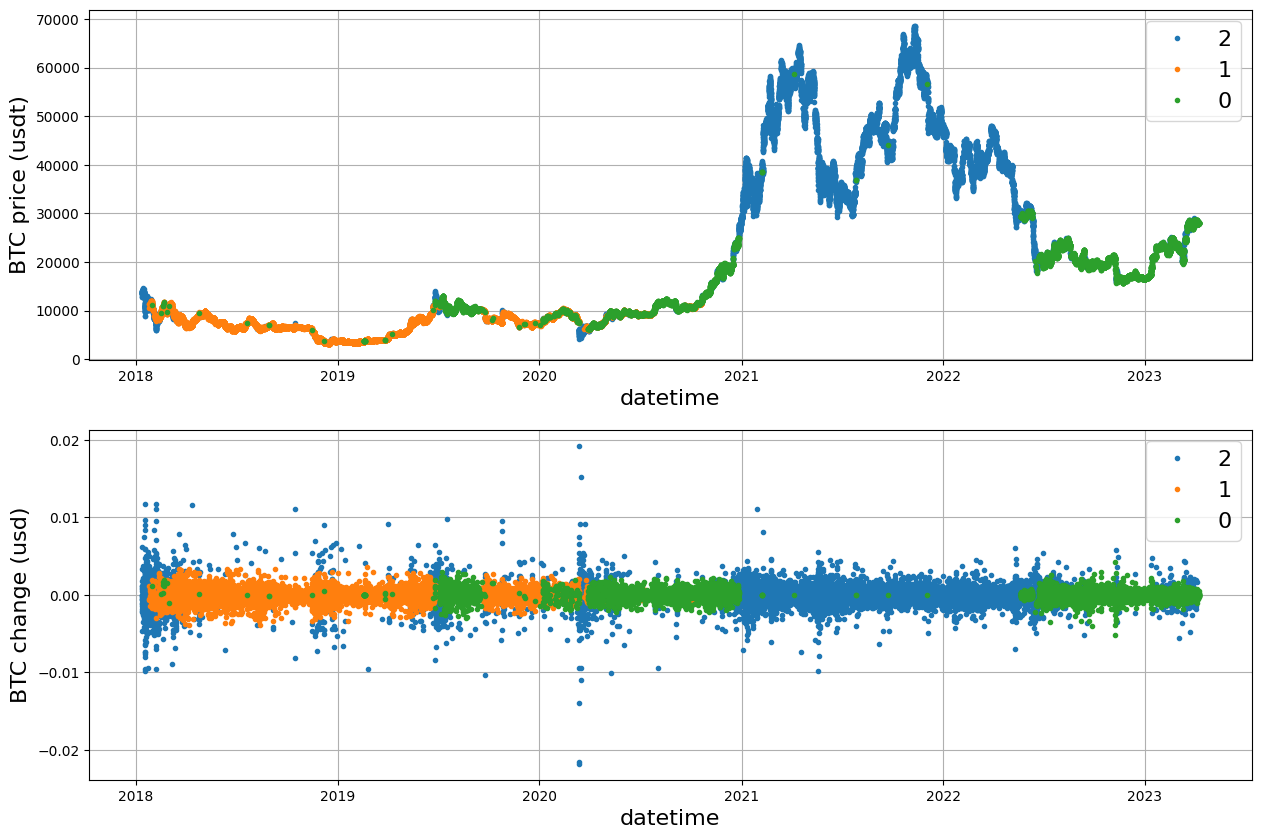

In [57]:
import matplotlib.pyplot as plt


data = pca_features
model = hmm.GaussianHMM(
    n_components=3, covariance_type="full", n_iter=50, random_state=42
)  # covariance_type = "diag"
model.fit(data)
model.score(data)

Z = model.predict(data)
states = pd.unique(Z)


plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
for i in states:
    want = Z == i
    x = df_BTC["Close"].iloc[want].index
    y = df_BTC["Close"].iloc[want]
    plt.plot(x, y, ".")
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("BTC price (usdt)", fontsize=16)
plt.subplot(2, 1, 2)
for i in states:
    want = Z == i
    x = df_BTC["Log_Returns"].iloc[want].index
    y = df_BTC["Log_Returns"].iloc[want]
    plt.plot(x, y, ".")
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("BTC change (usd)", fontsize=16)
plt.show()

# AutoHMM
